In [1]:
# import packages
import numpy as np
from tgcnn_act_graph import figures

### Example data:

Below we provide some example data.

The `filters` used should be extracted from the 3D CNN layer of the trained TG-CNN model.

The `input_tensors` are the graph representations of the individual patient pathways {INSERT TENSOR BUILDING GIF HERE}.

The `labels` are whether the patient had a positive (1) or negative (0) outcome.

Both the `filters` and the `input_tensors` should be 4D, `input_tensors` with shape (num_patients, num_timesteps,num_nodes, num_nodes) and `filters` with shape (num_filters, num_timesteps, num_nodes, num_nodes).

In [24]:
# Example Filters and Patients and Labels of whether they have a hip replacement (1) or not (0)

filters = np.array([[[[0, 0, 1], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 1, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]], 
                   [[[0, 1, 0], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 0, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]]])


input_tensors = np.array([[[[0, 0, 0], 
                          [0, 0, 3], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [0, 0, 0],
                                       [0, 4, 4]], [[0, 0, 0], 
                                                    [0, 2, 0], 
                                                    [0, 2, 0]], [[0, 0, 0], 
                                                                 [5, 0, 5], 
                                                                 [0, 0, 0]]],                        
                        [[[1, 0, 0], 
                          [1, 0, 0], 
                          [1, 0, 0]], [[8, 0, 0],
                                       [0, 0, 0],
                                       [0, 0, 0]], [[11, 11, 0], 
                                                    [0, 0, 0], 
                                                    [0, 0, 0]], [[0, 0, 30], 
                                                                 [0, 0, 30], 
                                                                 [0, 0, 0]]],                       
                          
                          [[[0, 0, 9], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [0, 0, 0],
                                       [7, 7, 0]], [[0, 0, 2], 
                                                    [0, 0, 2], 
                                                    [0, 0, 0]], [[0, 0, 0], 
                                                                 [0, 0, 0], 
                                                                 [1, 0, 0]]],                          
                          [[[1, 1, 1], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 1],
                                       [0, 0, 1],
                                       [0, 0, 1]], [[0, 0, 0], 
                                                    [0, 0, 0], 
                                                    [0, 1, 0]], [[0, 0, 0], 
                                                                 [2, 2, 2], 
                                                                 [0, 0, 0]]]]
                        
                        )


labels = [0, 1, 1, 0] #hip_replacement labels

### Code to draw a patient graph with edge activation.

Filter 1 had the largest difference in activation.


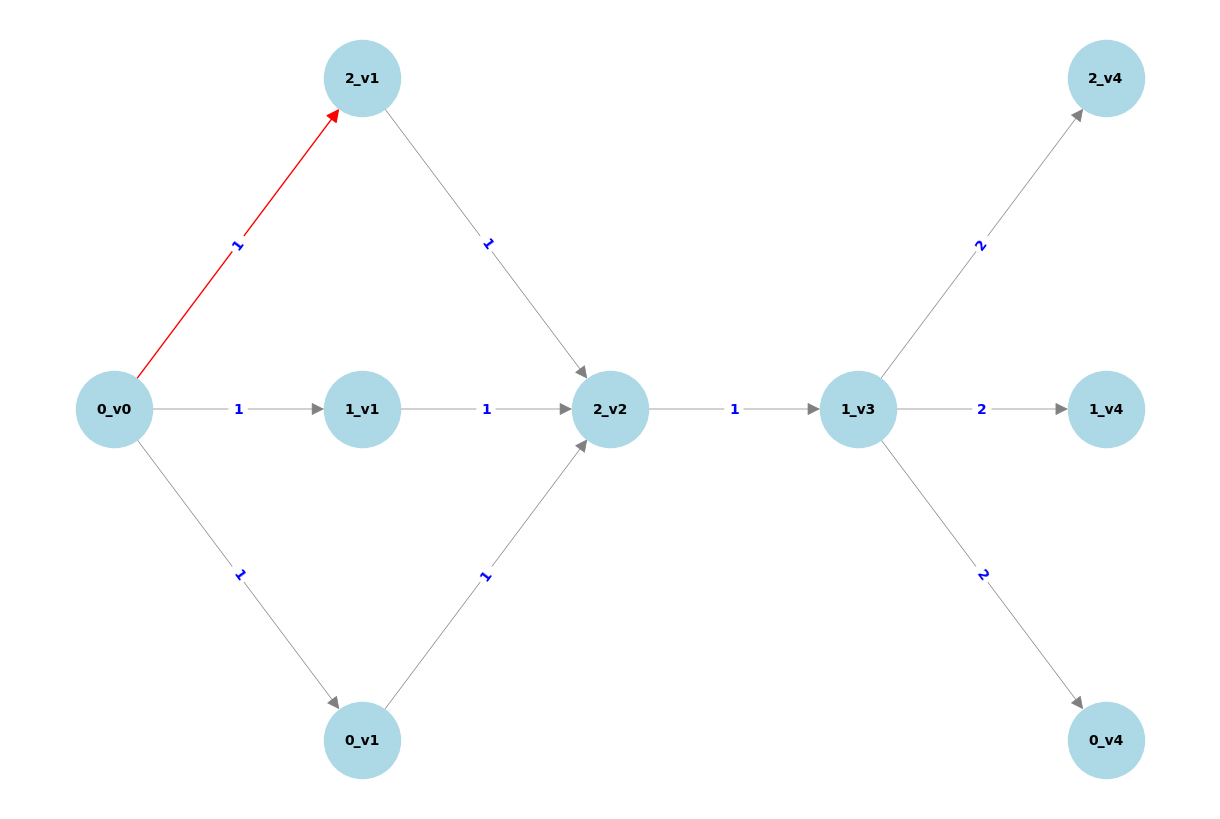

In [25]:
figures.edge_activated_graph(input_tensors=input_tensors, patient_number=3, filters=filters, labels=labels,  verbose=False, show_plot=False)